In [7]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

from fbprophet import Prophet

In [8]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

train['date_time'] = pd.to_datetime(train['Date'])
test['date_time'] = pd.to_datetime(test['Date'])

# train.date_time.dt.year
# train.date_time.dt.month

In [9]:
train['year'] = train.date_time.dt.year
train['month'] = train.date_time.dt.month
train['day'] = train.date_time.dt.day
train['weekday'] = train.date_time.dt.weekday

## EDA

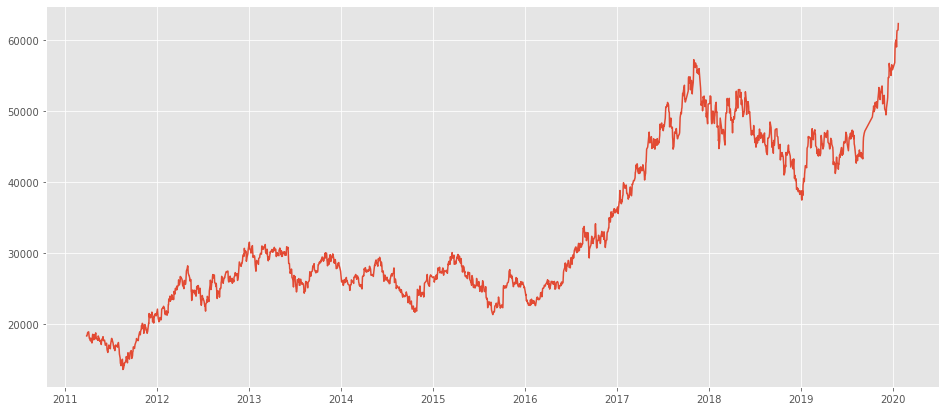

In [10]:
plt.figure(figsize=(16,7))
plt.plot(train['date_time'], train['Close'])
plt.show()

전체적인 주가 변동을 확인해보면 2012년 부터 2016년까지는 크게 변화가 없지만,
2016년 말부터 주가가 크게 상승하고 2018년에 최고점을 찍고, 다시 하락하였다가
2020년부터 다시 크게 증가하는 추세를 보인다.

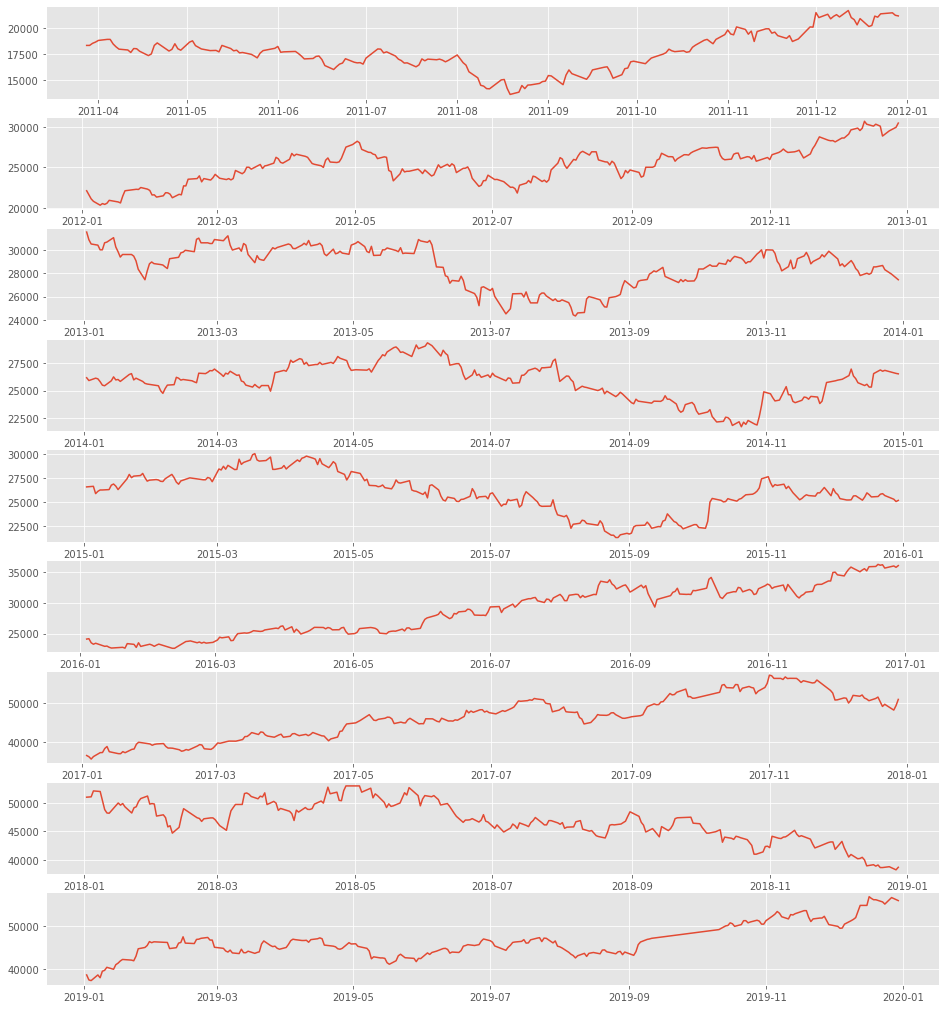

In [11]:
fig, axs = plt.subplots(figsize=(16,18), nrows=9)
idx = 0
for y in range(2011, 2020):
    axs[idx].plot(train[train.year == y].date_time, train[train.year == y].Close)
    idx += 1
plt.show()

- 연도별  

연도별 주가 변동을 확인해보면 앞에서 확인해본 결과와 마찬가지로 2015년 까지는
주가 변동의 추세가 없지만, 2016, 2017년은 꾸준하게 증가하는 추세 확인이 가능하다.
그리고 2018년에 주가가 조금 떨어지는 경향이 있지만, 2019년에 다시 증가하는 경향을 보인다.

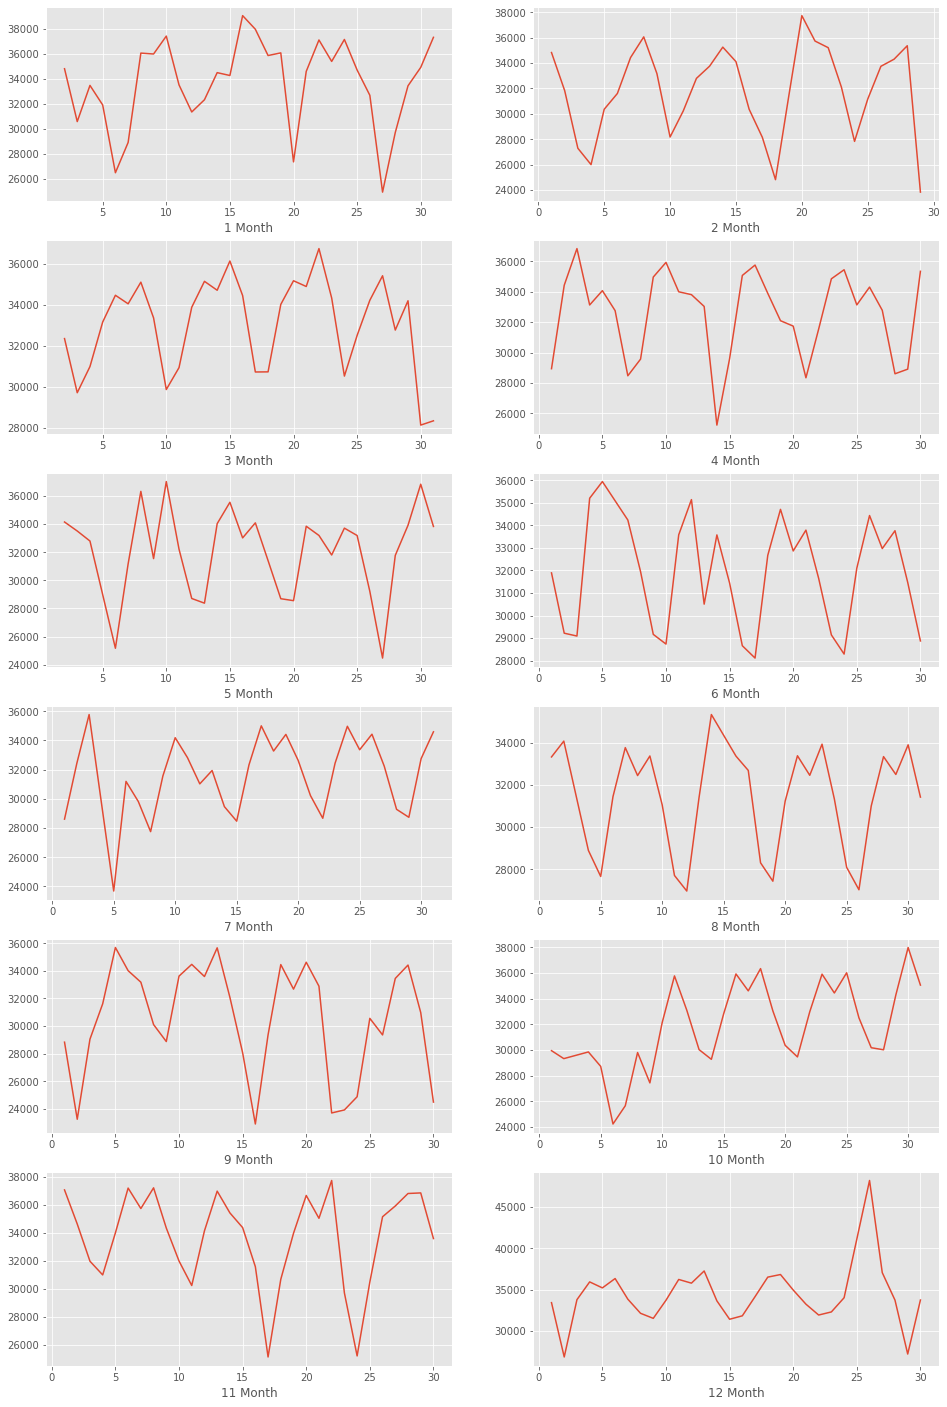

In [12]:
fig, axs = plt.subplots(figsize=(16,25), nrows=6, ncols=2)
idx = 0
for m in range(1, 13):
    col = idx % 2
    row = idx // 2
    axs[row, col].plot(train[train.month == m].groupby('day').mean().Close)
    axs[row, col].set_xlabel(f'{m} Month')
    idx += 1
plt.show()

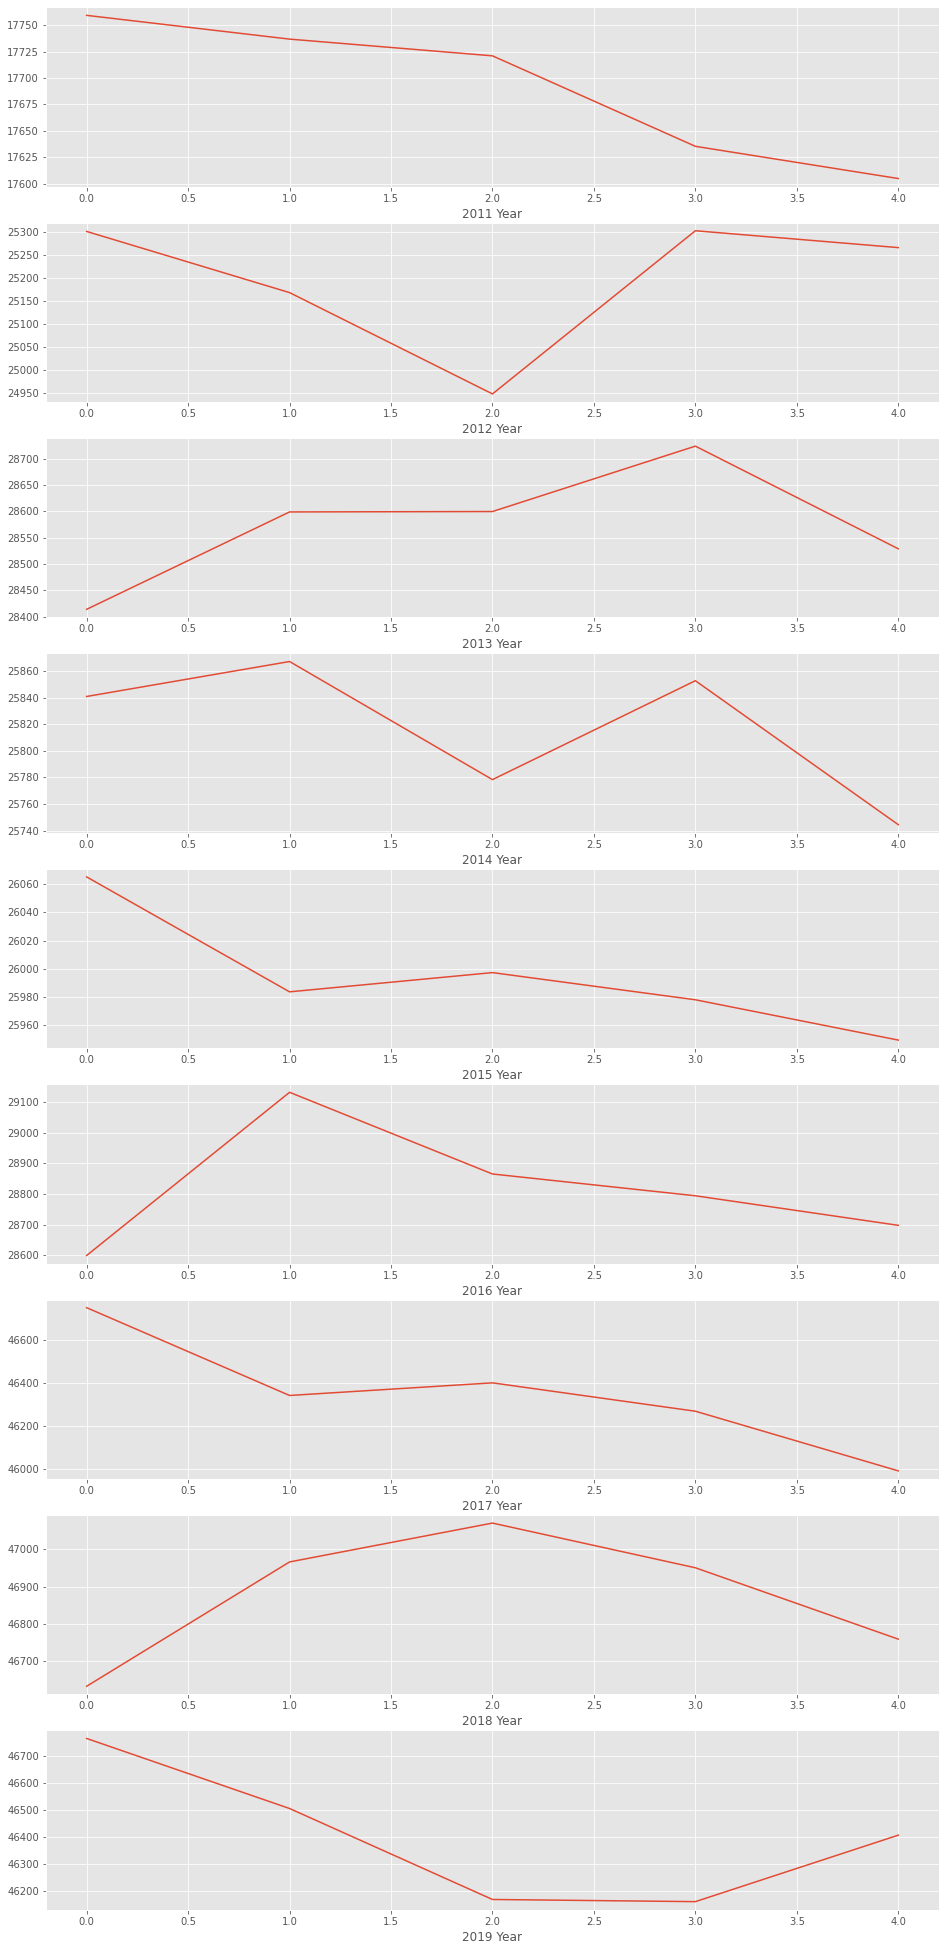

In [13]:
fig, axs = plt.subplots(figsize=(16,35), nrows=9)
idx = 0
for y in range(2011, 2020):
    axs[idx].plot(train[train.year == y].groupby('weekday').mean().Close)
    axs[idx].set_xlabel(f'{y} Year')
    idx += 1
plt.show()

- 요일별  

요일별 주가 변동을 확인해보면 월,화,수,목은 큰 특징을 발견하지 못했지만
2019년을 제외한 대부분 연도에서 금요일은 전날인 목요일에 비해 주가가 떨어지는 경향을 보인다.

In [14]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(train.iloc[:, 1:9])
scaled_data = scaler.transform(train.iloc[:, 1:9])

scaled_train = train.copy()
scaled_train.iloc[:, 1:9] = scaled_data

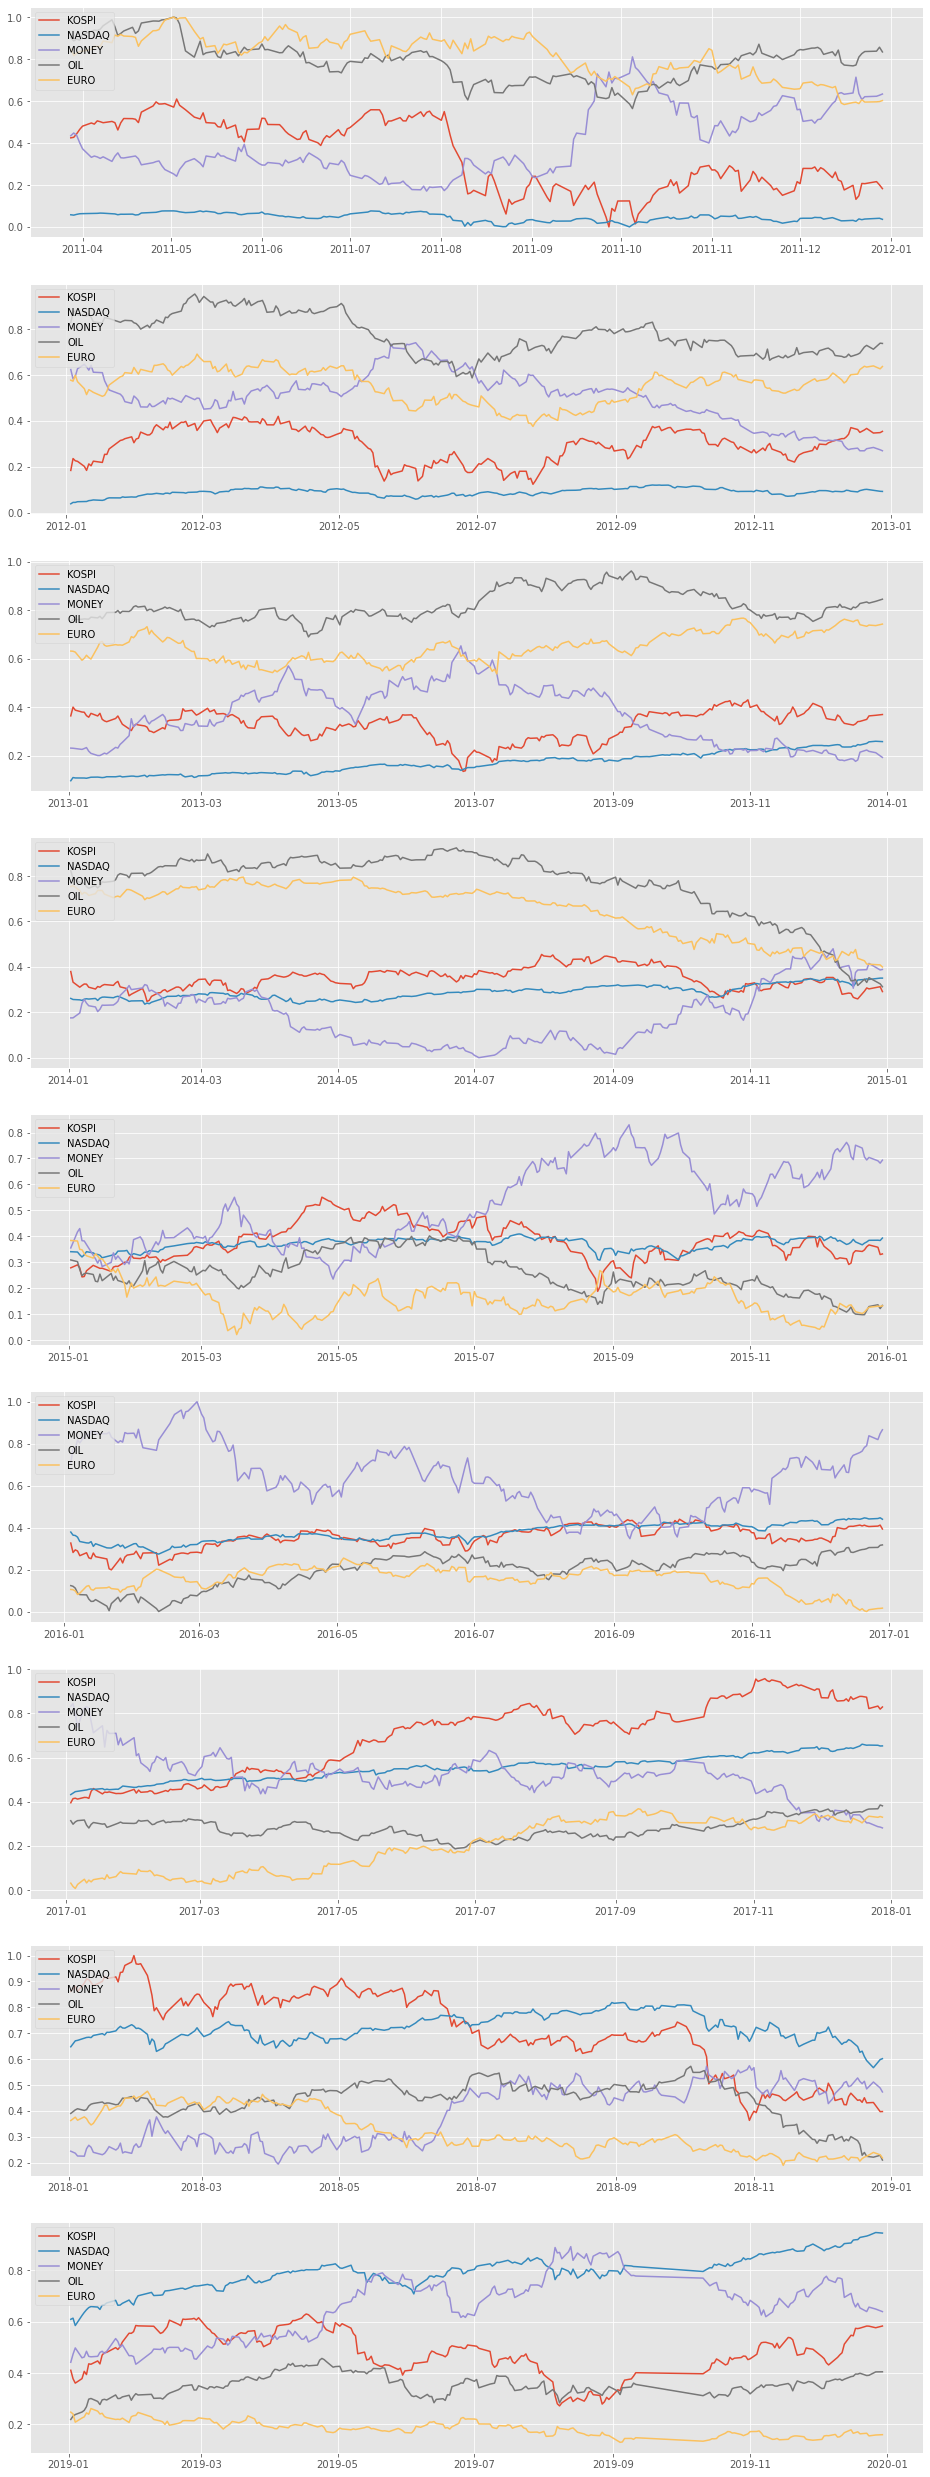

In [15]:
fig, axs = plt.subplots(figsize=(16,45), nrows=9)
idx = 0
for y in range(2011, 2020):
    axs[idx].plot(scaled_train[scaled_train.year == y].date_time, scaled_train[scaled_train.year == y].kospi, label='KOSPI')
    axs[idx].plot(scaled_train[scaled_train.year == y].date_time, scaled_train[scaled_train.year == y].nasdaq, label='NASDAQ')
    axs[idx].plot(scaled_train[scaled_train.year == y].date_time, scaled_train[scaled_train.year == y].money, label='MONEY')
    axs[idx].plot(scaled_train[scaled_train.year == y].date_time, scaled_train[scaled_train.year == y].oil, label='OIL')
    axs[idx].plot(scaled_train[scaled_train.year == y].date_time, scaled_train[scaled_train.year == y].euro, label='EURO')
    axs[idx].legend(loc='upper left')
    idx += 1
plt.show()

- 연도별 Feature  

연도별 feature들의 변동을 확인해보면 2017년에 KOSPI 지수가 확연하게 증가했으며 이로 인해 주가도
크게 증가했음을 예상해볼수있다. 그리고 반대로 2018년 중반부터 KOSPI 지수가 하락함과 동시에 
주가도 함께 떨어졌음을 알 수 있다.

## ARIMA

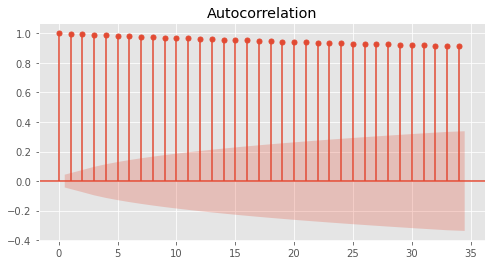

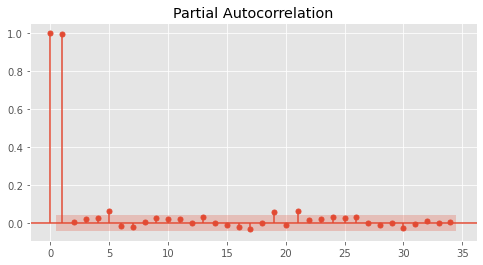

In [16]:
# AR의 특성
# ACF는 천천히 감소하고, PACF는 처음 시차를 제외하고 급격히 감소

# MA의 특성
# ACF는 급격히 감소하고, PACF는 처음 시차를 제외하고 천천히 감소

plt.rc("figure", figsize=(8,4))
plot_acf(train.Close.values)
plot_pacf(train.Close.values)
plt.show()

- ACF, PACF

주가에 대한 ACF(AutoCorrelationFunction)과 PACF(PartialAutoCorrelationFunction)을 확인해보면
ACF는 천천히 감소하고 PACF는 특정 시차 이후로 급격히 감소한 모습으로 보아 주가 데이터는
AR모형에 가깝다고 판단했다.
>ACF가 천천히 감소하는 경우, 비정상 시계열  
>ACF가 급격히 감소하는 경우, 정상 시계열  
>ACF가 불규칙적인 변동을 보이는 경우, 정상 시계열

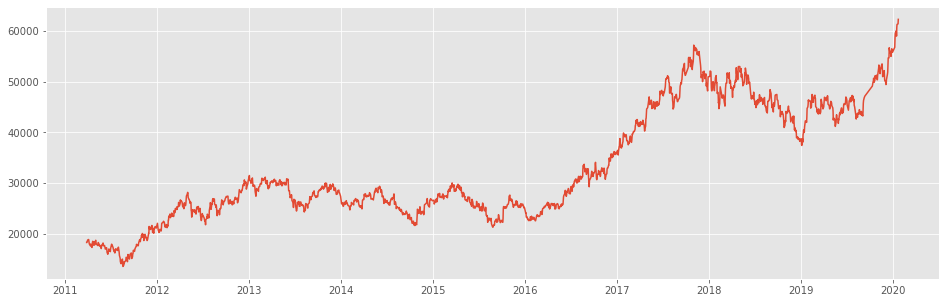

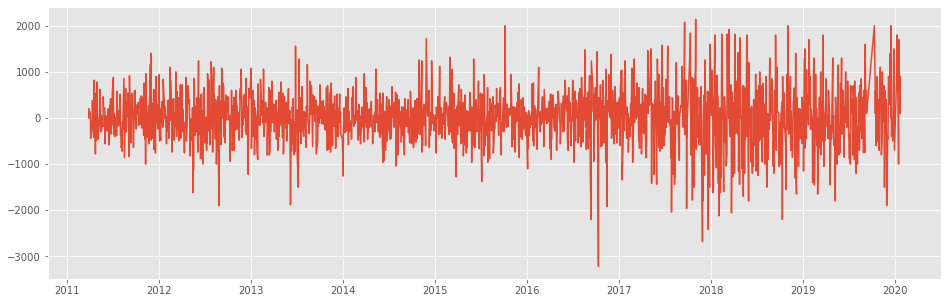

In [17]:
# 1차 차분을 시행하여 어느정도 WhiteNoise의 형태를 보인다.

diff_train = train[['date_time', 'Close']]
diff = diff_train.Close.diff(periods=1).iloc[1:]
diff_train = diff_train.iloc[1:, :]
diff_train.iloc[:, 1] = diff

plt.figure(figsize=(16,5))
plt.plot(train['date_time'], train['Close'])
plt.figure(figsize=(16,5))
plt.plot(diff_train.date_time, diff_train.Close)
plt.show()

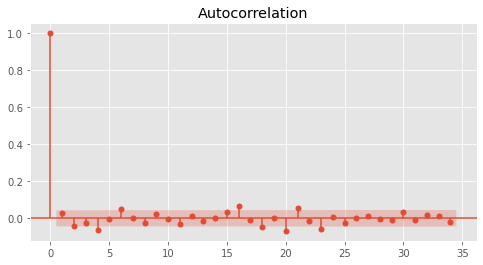

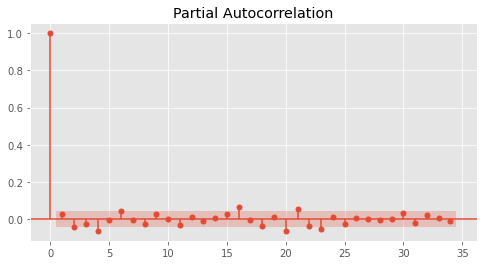

In [18]:
# 1차 차분만으로 정상시계열의 ACF와 PACF 값을 보인다.

plt.rc("figure", figsize=(8,4))
plot_acf(diff_train.Close)
plot_pacf(diff_train.Close)
plt.show()

**1차 차분을 진행한 후 데이터의 흐름이 어느정도 WhiteNoise의 형태를 보인다.
ACF와 PACF도 급격히 감소한 정상 시계열 데이터로 판단된다.**

In [19]:
model_arima = auto_arima(train.Close.values, trace=True, 
                         error_action='ignore', 
                         start_p=1, start_q=1, max_p=3, max_q=3, 
                         suppress_warnings=True, stepwise=False, seasonal=False)
model_arima.fit(train.Close.values)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=31920.039, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=31920.602, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=31919.318, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=31920.182, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=31920.706, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31920.815, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=31920.252, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=31921.193, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=31919.497, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=31917.628, Time=1.10 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31916.469, Time=2.16 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=31920.291, Time=1.43 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=31920.220, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=31920.550, Time=0.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=31920.233, Time=1.27

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [20]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

model = ARIMA(train.Close.values, order = (2,1,2))
model_fit = model.fit(trend = 'c', full_output = True, disp = True)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 2051
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -15951.642
Method:                       css-mle   S.D. of innovations            577.408
Date:                Thu, 01 Jul 2021   AIC                          31915.283
Time:                        07:42:46   BIC                          31949.040
Sample:                             1   HQIC                         31927.662
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.4292     12.098      1.771      0.077      -2.282      45.140
ar.L1.D.y      1.2185      0.133      9.176      0.000       0.958       1.479
ar.L2.D.y     -0.7922      0.137     -5.797      0.0

AutoARIMA를 시행하여 적합한 p,d,q 값을 찾아보니 ARIMA(2,1,2)가 적합한 모델로 나와 모델링을 진행하였다.  
**모든 계수가 유의수준 0.05에서 유의하다고 판단되었고, 상수값만 유의하지 않다는 결과가 나왔다.**

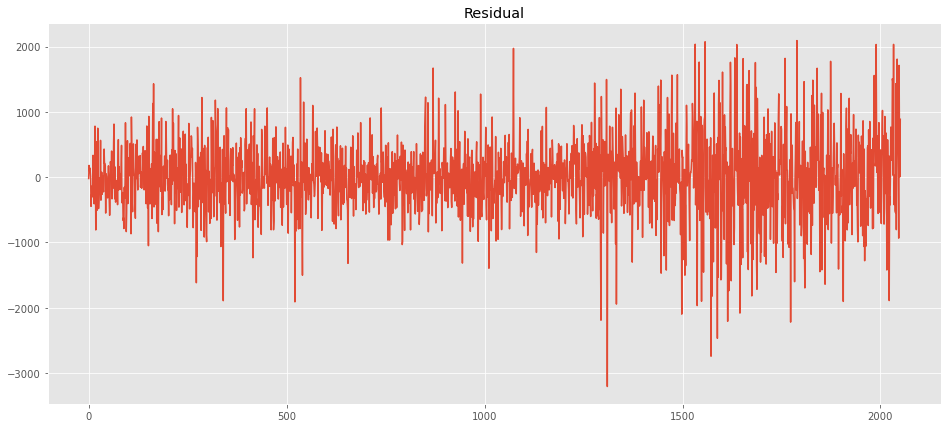

In [21]:
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(16, 7))
plt.plot(residuals)
plt.title('Residual')
plt.show()

In [22]:
forecast_data = model_fit.forecast(steps=337) 

forecast = pd.DataFrame(forecast_data[0], columns=['forecast'])
forecast['date_time'] = test.date_time

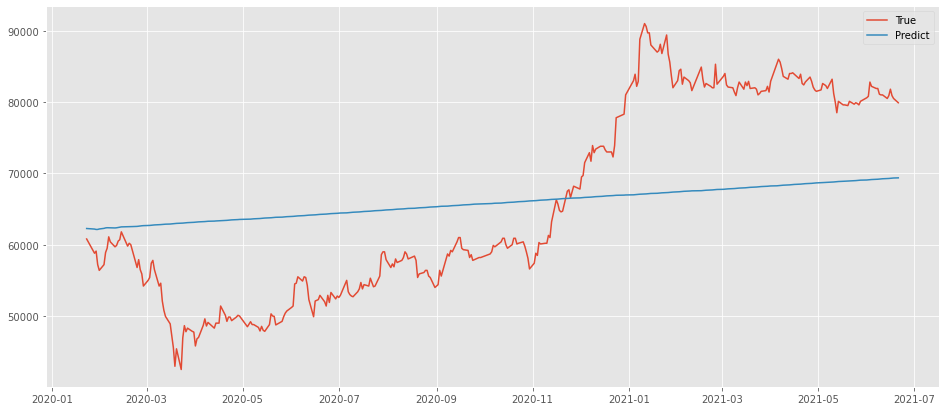

In [17]:
plt.figure(figsize=(16,7))
plt.plot(test['date_time'], test['Close'], label='True')
plt.plot(forecast['date_time'], forecast['forecast'], label='Predict')
plt.legend()
plt.show()

- Result  
예측값은 주가가 최종적으로 증가하는 경향을 보이는 형태로 판단했는데, 실제 데이터와 비교해보니
실제 값도 점차 증가하는 형태를 보이고 있었다.**ARIMA를 통해 주가의 정확한 값이나 주기적인 변동을
정확하게 확인하진 못하지만, 주가가 증가할지 감소할지 경향정도는 어느정도 예측이 가능할것으로 보인다.**

In [18]:
prophet_train = train[['date_time', 'Close']].copy()
prophet_train.columns = ['ds', 'y']

In [19]:
prophet = Prophet(seasonality_mode = 'multiplicative',
                 yearly_seasonality=True, 
                 weekly_seasonality=True,
                 daily_seasonality=True,
                 changepoint_prior_scale=0.5)

prophet.fit(prophet_train)

In [20]:
future_data = prophet.make_future_dataframe(periods=516, freq = 'd')
forecast_data = prophet.predict(future_data)

forecast_data = forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_data.columns = ['date_time', 'predict', 'lower', 'upper']

true_data = test[['date_time', 'Close']].copy()
result_data = true_data.merge(forecast_data, on='date_time', how='left')

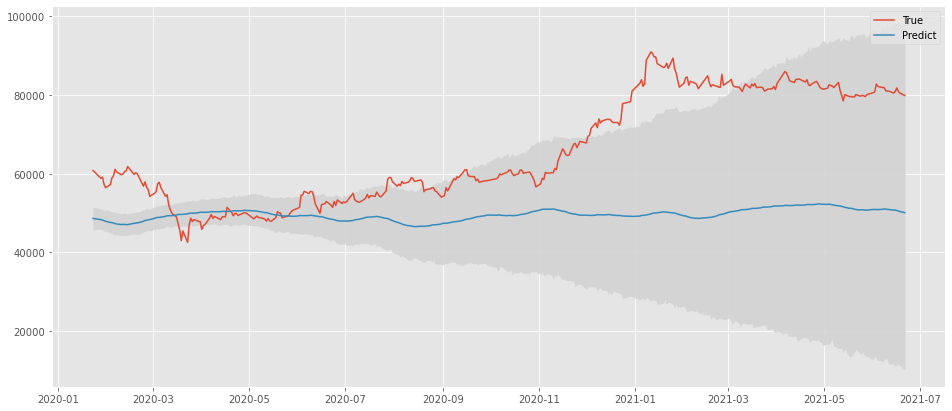

In [21]:
plt.figure(figsize=(16,7))
plt.plot(result_data['date_time'], result_data['Close'], label='True')
plt.plot(result_data['date_time'], result_data['predict'], label='Predict')
plt.fill_between(result_data['date_time'], result_data['lower'], result_data['upper'], color='lightgray', alpha=0.9)
plt.legend()
plt.show()